# Validating Alaska Lightning Probability Model

In this notebook you will learn:

- how to visualize model output data
- how to perform quick statistics and exploratory data analysis
- how to get model metrics for validation

For this part of the work we will be looking at outputs from the trained model on ALDN data. We will look at the model performance under:

- general conditions
- per biome
- per severity day
- per temporal window.

You will use the base code from the previous notebook to finish the last three plots from this notebook. I have provided examples below on how you can query the data and use it to plot.

## 1. Open database to work with

We will use a database to validate our model. This database includes observations across all dates, biomes, and temporal windows.

In [ ]:
!pip install datasets geopandas

In [55]:
import pandas as pd
import geopandas as gpd
from huggingface_hub import snapshot_download
from sklearn.metrics import accuracy_score, confusion_matrix, \
    classification_report, brier_score_loss, log_loss

In [56]:
DATASET_URL = 'jordancaraballo/alaska-lightning'
DATASET_FILENAME = 'validation-alaska.gpkg'

In [63]:
#database_filename = '/explore/nobackup/people/jacaraba/development/wildfire-occurrence/notebooks/validation-alaska.gpkg'
alaska_dataset = snapshot_download(repo_id=DATASET_URL, allow_patterns="*.gpkg", repo_type='dataset')

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [64]:
database_filename = os.path.join(alaska_dataset, DATASET_FILENAME)
database_filename

'/home/jacaraba/.cache/huggingface/hub/datasets--jordancaraballo--alaska-lightning/snapshots/4fb86c0555e59021c8fa5130905707039242ecd6/validation-alaska.gpkg'

In [65]:
validation_database = gpd.read_file(database_filename)

In [39]:
validation_database.head()

,BIOME,CFTotal,CFLow,CFMed,CFHigh,DZ700_850,GPZ500,GPZ700,GPZ750,GPZ850,...,T750,T850,W500,WA500,WRFDATE_STR,Severity2,predictions,predictions_proba,Label,geometry
0,BOREAL,0.235118,0.000000,0.555937,0.149419,1587.271973,5683.688477,3076.060059,2522.620117,1488.788086,...,-0.241375,-0.647393,-0.010574,-0.009586,2015-06-21,Severe,1,0.952536,1,POINT (519194.241 1898993.900)
1,TUNDRA,0.367650,0.536280,0.373804,0.192867,1565.920166,5591.059570,3004.359131,2454.425293,1438.438965,...,-3.937138,-7.394337,-0.032130,-0.014873,2022-07-03,Severe,0,0.025289,0,POINT (-192638.360 1034422.002)
2,TUNDRA,0.000000,0.000000,0.000000,0.000000,1582.987427,5700.426270,3100.707520,2546.743408,1517.720093,...,-0.869709,-3.584895,-0.068340,-0.077150,2015-06-21,Severe,0,0.023028,0,POINT (-602795.019 1377084.527)
3,BOREAL,0.638786,0.667094,1.000000,0.249264,1590.126587,5690.891113,3077.050781,2518.399414,1486.924194,...,0.635090,-3.608742,0.100535,0.041435,2022-07-03,Severe,1,0.502581,0,POINT (243477.581 1377084.527)
4,TUNDRA,0.398346,0.609287,0.541084,0.044667,1557.165405,5551.070312,2978.733887,2431.038086,1421.568481,...,-5.159317,-10.262680,-0.007419,-0.006713,2013-06-20,Severe,0,0.013615,0,POINT (-109568.657 868282.596)


## 2. Basic Accuracy Metrics - Biome

In [40]:
def print_accuracy(df):
    conf_matrix = confusion_matrix(df['Label'], df['predictions'])
    a = conf_matrix[0][0]
    b = conf_matrix[0][1]
    c = conf_matrix[1][0]
    d = conf_matrix[1][1]

    print("Accuracy: ", accuracy_score(df['Label'], df['predictions']))
    print("POD:      ", a / (a+c))
    print("CSI:      ", a / (a+b+c))
    print("FAR:      ", b / (a+c))
    print("F:        ", b / (b+d))
    print("Brier:    ", brier_score_loss(df['Label'], df['predictions_proba']))
    print("Log Loss: ", log_loss(df['Label'], df['predictions_proba']))
    return

In [41]:
# Overall Accuracy, Alaska
print_accuracy(validation_database)

Accuracy:  0.8701488182083454
POD:       0.8993288590604027
CSI:       0.766066500197135
FAR:       0.17395664583815476
F:         0.156022971009479
Brier:     0.0937261217448091
Log Loss:  0.3061215240577065


In [42]:
# Overall Accuracy, Tundra
tundra = validation_database[validation_database['BIOME'] == 'TUNDRA']
print_accuracy(tundra)

Accuracy:  0.9013016555036016
POD:       0.9352299159062444
CSI:       0.8700066577896138
FAR:       0.07496868849525855
F:         0.18029259896729777
Brier:     0.07140649806817509
Log Loss:  0.23639188980476725


In [43]:
# Overall Accuracy, Boreal
boreal = validation_database[validation_database['BIOME'] == 'BOREAL']
print_accuracy(boreal)

Accuracy:  0.8491005996002665
POD:       0.8475700779565434
CSI:       0.6527848748083802
FAR:       0.2983911096367557
F:         0.15012934991237586
Brier:     0.10864986889151163
Log Loss:  0.35152271423266934


## 3. Basic Accuracy Metrics - Severity

In [44]:
# Overall Accuracy, Severe
severe = validation_database[validation_database['Severity2'] == 'Severe']
print_accuracy(severe)

Accuracy:  0.8680068567866605
POD:       0.8967855349070819
CSI:       0.7597333522445217
FAR:       0.18039511133433786
F:         0.15704707768546858
Brier:     0.09542416002537023
Log Loss:  0.31109003815600383


In [45]:
# Overall Accuracy, Moderate
moderate = validation_database[validation_database['Severity2'] == 'Moderate']
print_accuracy(moderate)

Accuracy:  0.8816176470588235
POD:       0.9068047337278107
CSI:       0.7919896640826873
FAR:       0.14497041420118342
F:         0.14327485380116958
Brier:     0.08114471707250948
Log Loss:  0.26681248977472327


In [46]:
# Overall Accuracy, Low
low = validation_database[validation_database['Severity2'] == 'Low']
print_accuracy(low)

Accuracy:  0.9716494845360825
POD:       0.9736070381231672
CSI:       0.967930029154519
FAR:       0.005865102639296188
F:         0.0425531914893617
Brier:     0.02549278094296501
Log Loss:  0.11521551052615858


## Example plot - which dates are we performing the worst?

Text(0, 0.5, 'Date')

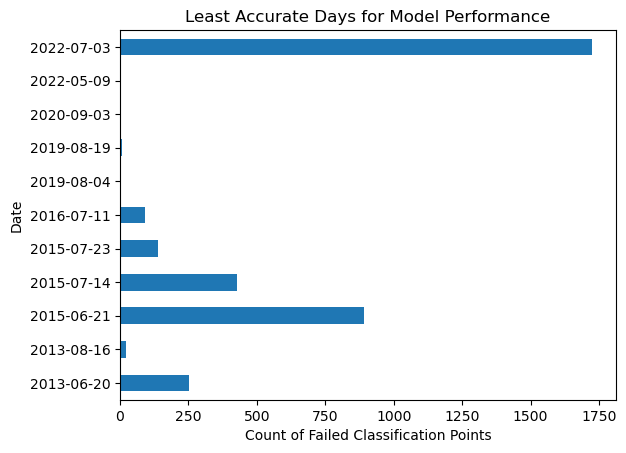

In [53]:
failed_points = validation_database[validation_database['Label'] != validation_database['predictions']]
ax = failed_points.WRFDATE_STR.value_counts().sort_index().plot(
    kind='barh', title='Least Accurate Days for Model Performance')
ax.set_xlabel("Count of Failed Classification Points")
ax.set_ylabel("Date")

## Example plot - which dates are we performing the best?

Text(0, 0.5, 'Date')

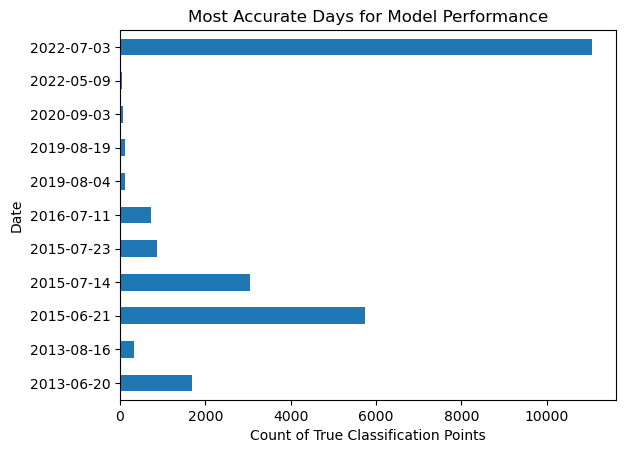

In [54]:
accurate_points = validation_database[validation_database['Label'] == validation_database['predictions']]
ax = accurate_points.WRFDATE_STR.value_counts().sort_index().plot(
    kind='barh', title='Most Accurate Days for Model Performance')
ax.set_xlabel("Count of True Classification Points")
ax.set_ylabel("Date")

The pattern between these two seems to be related to the number of points available. It would be interesting to understand if there are any climate variables driving this difference.

## 4. Task #1: Generate Bar Plot with Accuracy per Location (Boreal vs Tundra)

In [47]:
### Insert your code Here ###

## 5. Task #2: Generate Bar Plot with Accuracy per Severity Level (Severe, Moderate, Low)

In [48]:
### Insert your code Here ###

## 6. Task #3: Generate Map to Illustrate where our model fails the most

In [49]:
### Insert your code Here ###

## 7. Task #4: Write three conclusions from the results listed above

In [50]:
### Insert your text Here ###